# Tensorflow.keras implementation of full precision shifted ReLU CNN for CIFAR 100 
##  https://arxiv.org/abs/1907.06916
## Mark D. McDonnell, Hesham Mostafa, Runchun Wang, Andre van Schaik,
## Single-bit-per-weight deep convolutional neural networks without batch-normalization layers for embedded systems

In [1]:
# select a GPU
import os
os.environ["CUDA_DEVICE_ORDER"] = 'PCI_BUS_ID'
os.environ["CUDA_VISIBLE_DEVICES"] = '1'

import numpy as np
import h5py
import matplotlib.pyplot as plt
import copy
from scipy.io import savemat,loadmat
import warnings
warnings.filterwarnings('ignore',category=FutureWarning)

import tensorflow
print('Tensorflow version = ',tensorflow.__version__)
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import LearningRateScheduler, History

#from tensorflow.keras import backend as K

from ResNetModel import resnet_srelu
from Utils import cutout,LR_WarmRestart,GetDataGen,plot_history

Tensorflow version =  1.13.1


In [2]:
#params
#WhichDataSet = 'CIFAR10'
WhichDataSet = 'CIFAR100'
init_lr = 0.1
epochs = 300
batch_size = 125
My_wd=5e-4/2
resnet_width = 10
resnet_depth = 20
UseBinary=False
UseCutout=True
Loss = 'categorical_crossentropy'
Optimizer = SGD(lr=init_lr,decay=0.0, momentum=0.9, nesterov=False)
Metrics = ['accuracy']
ModelsPath = 'TrainedModels/Tensorflow.keras/'

Instructions for updating:
Colocations handled automatically by placer.


In [3]:
#load and prepare data
if WhichDataSet == 'CIFAR10':
    (x_train, y_train), (x_test, y_test) = tensorflow.keras.datasets.cifar10.load_data()
else:
    (x_train, y_train), (x_test, y_test) = tensorflow.keras.datasets.cifar100.load_data()
num_classes = np.unique(y_train).shape[0]
K_train = x_train.shape[0]
input_shape = x_train.shape[1:]
x_train = x_train.astype('float32')/255.0
x_test = x_test.astype('float32')#/255.0
y_train = tensorflow.keras.utils.to_categorical(y_train, num_classes)
y_test = tensorflow.keras.utils.to_categorical(y_test, num_classes)


In [4]:
def catcross_entropy_logits_loss():
    def loss(y_true, y_pred):
        return tensorflow.keras.losses.categorical_crossentropy(y_true, y_pred, from_logits=True)
    return loss

In [5]:
#define a datagen or generating training samples with flip and pad/crop augmentation, and if set to True, with cutout augmentation
dataGenerator = GetDataGen(UseCutout)

#define and compile the model
Temperature=25.0
model = resnet_srelu(Temperature,UseBinary,input_shape=input_shape, depth=resnet_depth, num_classes=num_classes,
                     wd=My_wd,width=resnet_width)
model.compile(loss=catcross_entropy_logits_loss() ,optimizer = Optimizer, metrics = Metrics)

#print  the model
model.summary()

#define the learnng rate schedule
steps_per_epoch = int(np.floor(K_train / batch_size))
lr_scheduler = LR_WarmRestart(nbatch=steps_per_epoch,
                              initial_lr=init_lr, min_lr=init_lr*1e-4,
                              epochs_restart = [],
                              Tmult=300.0) 

#define callbacks
history = History()
callbacks = [lr_scheduler,history]

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
batch_normalization_v1 (BatchNo (None, 32, 32, 3)    12          input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 160)  4320        batch_normalization_v1[0][0]     
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 32, 32, 160)  0           conv2d[0][0]                     
__________________________________________________________________________________________________
re_lu (ReL

In [6]:
history = model.fit_generator(dataGenerator.flow(x_train, y_train, batch_size=batch_size),
                              validation_data=(x_test, y_test),
                              epochs=epochs,
                              verbose=1,
                              callbacks=callbacks,
                              steps_per_epoch =steps_per_epoch)

Instructions for updating:
Use tf.cast instead.

 Start of Epoch Learning Rate = 0.100000
Epoch 1/300
10000/10000 [==============================] - 7s 745us/sample - loss: 6.5205 - acc: 0.0612

 End of Epoch Learning Rate = 0.099997
400/400 [==============================] - 124s 311ms/step - loss: 7.4122 - acc: 0.0264 - val_loss: 6.5205 - val_acc: 0.0612

 Start of Epoch Learning Rate = 0.099997
Epoch 2/300
10000/10000 [==============================] - 7s 717us/sample - loss: 5.3521 - acc: 0.1359

 End of Epoch Learning Rate = 0.099989
400/400 [==============================] - 117s 293ms/step - loss: 5.9849 - acc: 0.0857 - val_loss: 5.3521 - val_acc: 0.1359

 Start of Epoch Learning Rate = 0.099989
Epoch 3/300
10000/10000 [==============================] - 7s 712us/sample - loss: 4.5927 - acc: 0.1946

 End of Epoch Learning Rate = 0.099975
400/400 [==============================] - 117s 293ms/step - loss: 5.0053 - acc: 0.1563 - val_loss: 4.5927 - val_acc: 0.1946

 Start of Epoch Le

10000/10000 [==============================] - 7s 708us/sample - loss: 2.4559 - acc: 0.6430

 End of Epoch Learning Rate = 0.098158
400/400 [==============================] - 117s 292ms/step - loss: 2.3305 - acc: 0.6546 - val_loss: 2.4559 - val_acc: 0.6430

 Start of Epoch Learning Rate = 0.098158
Epoch 27/300
10000/10000 [==============================] - 7s 715us/sample - loss: 2.4193 - acc: 0.6440

 End of Epoch Learning Rate = 0.098015
400/400 [==============================] - 117s 291ms/step - loss: 2.3439 - acc: 0.6512 - val_loss: 2.4193 - val_acc: 0.6440

 Start of Epoch Learning Rate = 0.098015
Epoch 28/300
10000/10000 [==============================] - 7s 713us/sample - loss: 2.4082 - acc: 0.6419

 End of Epoch Learning Rate = 0.097866
400/400 [==============================] - 117s 291ms/step - loss: 2.3394 - acc: 0.6547 - val_loss: 2.4082 - val_acc: 0.6419

 Start of Epoch Learning Rate = 0.097866
Epoch 29/300
10000/10000 [==============================] - 7s 711us/sample -

10000/10000 [==============================] - 7s 710us/sample - loss: 2.4788 - acc: 0.6619

 End of Epoch Learning Rate = 0.092769
400/400 [==============================] - 116s 291ms/step - loss: 2.2603 - acc: 0.6997 - val_loss: 2.4788 - val_acc: 0.6619

 Start of Epoch Learning Rate = 0.092769
Epoch 53/300
10000/10000 [==============================] - 7s 703us/sample - loss: 2.4347 - acc: 0.6707

 End of Epoch Learning Rate = 0.092495
400/400 [==============================] - 117s 291ms/step - loss: 2.2335 - acc: 0.7069 - val_loss: 2.4347 - val_acc: 0.6707

 Start of Epoch Learning Rate = 0.092495
Epoch 54/300
10000/10000 [==============================] - 7s 711us/sample - loss: 2.4222 - acc: 0.6686

 End of Epoch Learning Rate = 0.092217
400/400 [==============================] - 117s 292ms/step - loss: 2.2249 - acc: 0.7086 - val_loss: 2.4222 - val_acc: 0.6686

 Start of Epoch Learning Rate = 0.092217
Epoch 55/300
10000/10000 [==============================] - 7s 705us/sample -

10000/10000 [==============================] - 7s 709us/sample - loss: 2.4212 - acc: 0.6840

 End of Epoch Learning Rate = 0.084229
400/400 [==============================] - 117s 292ms/step - loss: 2.1237 - acc: 0.7386 - val_loss: 2.4212 - val_acc: 0.6840

 Start of Epoch Learning Rate = 0.084229
Epoch 79/300
10000/10000 [==============================] - 7s 708us/sample - loss: 2.4027 - acc: 0.6862

 End of Epoch Learning Rate = 0.083845
400/400 [==============================] - 117s 292ms/step - loss: 2.1140 - acc: 0.7408 - val_loss: 2.4027 - val_acc: 0.6862

 Start of Epoch Learning Rate = 0.083845
Epoch 80/300
10000/10000 [==============================] - 7s 725us/sample - loss: 2.4427 - acc: 0.6857

 End of Epoch Learning Rate = 0.083458
400/400 [==============================] - 118s 294ms/step - loss: 2.1350 - acc: 0.7342 - val_loss: 2.4427 - val_acc: 0.6857

 Start of Epoch Learning Rate = 0.083458
Epoch 81/300
10000/10000 [==============================] - 7s 715us/sample -

10000/10000 [==============================] - 7s 714us/sample - loss: 2.3126 - acc: 0.7002

 End of Epoch Learning Rate = 0.073167
400/400 [==============================] - 116s 291ms/step - loss: 1.9625 - acc: 0.7708 - val_loss: 2.3126 - val_acc: 0.7002

 Start of Epoch Learning Rate = 0.073167
Epoch 105/300
10000/10000 [==============================] - 7s 710us/sample - loss: 2.3974 - acc: 0.6985

 End of Epoch Learning Rate = 0.072702
400/400 [==============================] - 117s 292ms/step - loss: 1.9619 - acc: 0.7714 - val_loss: 2.3974 - val_acc: 0.6985

 Start of Epoch Learning Rate = 0.072702
Epoch 106/300
10000/10000 [==============================] - 7s 719us/sample - loss: 2.3592 - acc: 0.6973

 End of Epoch Learning Rate = 0.072235
400/400 [==============================] - 117s 292ms/step - loss: 1.9681 - acc: 0.7670 - val_loss: 2.3592 - val_acc: 0.6973

 Start of Epoch Learning Rate = 0.072235
Epoch 107/300
10000/10000 [==============================] - 7s 711us/sampl

10000/10000 [==============================] - 7s 720us/sample - loss: 2.3208 - acc: 0.7046

 End of Epoch Learning Rate = 0.060400
400/400 [==============================] - 117s 292ms/step - loss: 1.7689 - acc: 0.8052 - val_loss: 2.3208 - val_acc: 0.7046

 Start of Epoch Learning Rate = 0.060400
Epoch 131/300
10000/10000 [==============================] - 7s 704us/sample - loss: 2.3281 - acc: 0.7166

 End of Epoch Learning Rate = 0.059887
400/400 [==============================] - 117s 292ms/step - loss: 1.7762 - acc: 0.8032 - val_loss: 2.3281 - val_acc: 0.7166

 Start of Epoch Learning Rate = 0.059887
Epoch 132/300
10000/10000 [==============================] - 7s 709us/sample - loss: 2.3540 - acc: 0.6971

 End of Epoch Learning Rate = 0.059373
400/400 [==============================] - 116s 290ms/step - loss: 1.7656 - acc: 0.8070 - val_loss: 2.3540 - val_acc: 0.6971

 Start of Epoch Learning Rate = 0.059373
Epoch 133/300
10000/10000 [==============================] - 7s 710us/sampl

10000/10000 [==============================] - 7s 699us/sample - loss: 2.1536 - acc: 0.7287

 End of Epoch Learning Rate = 0.046866
400/400 [==============================] - 116s 290ms/step - loss: 1.5361 - acc: 0.8460 - val_loss: 2.1536 - val_acc: 0.7287

 Start of Epoch Learning Rate = 0.046866
Epoch 157/300
10000/10000 [==============================] - 7s 707us/sample - loss: 2.1841 - acc: 0.7242

 End of Epoch Learning Rate = 0.046343
400/400 [==============================] - 116s 291ms/step - loss: 1.5279 - acc: 0.8453 - val_loss: 2.1841 - val_acc: 0.7242

 Start of Epoch Learning Rate = 0.046343
Epoch 158/300
10000/10000 [==============================] - 7s 714us/sample - loss: 2.2185 - acc: 0.7155

 End of Epoch Learning Rate = 0.045822
400/400 [==============================] - 116s 291ms/step - loss: 1.5228 - acc: 0.8464 - val_loss: 2.2185 - val_acc: 0.7155

 Start of Epoch Learning Rate = 0.045822
Epoch 159/300
10000/10000 [==============================] - 7s 715us/sampl

10000/10000 [==============================] - 7s 713us/sample - loss: 2.0753 - acc: 0.7294

 End of Epoch Learning Rate = 0.033563
400/400 [==============================] - 117s 292ms/step - loss: 1.2831 - acc: 0.8818 - val_loss: 2.0753 - val_acc: 0.7294

 Start of Epoch Learning Rate = 0.033563
Epoch 183/300
10000/10000 [==============================] - 7s 697us/sample - loss: 2.1244 - acc: 0.7255

 End of Epoch Learning Rate = 0.033070
400/400 [==============================] - 117s 291ms/step - loss: 1.2921 - acc: 0.8805 - val_loss: 2.1244 - val_acc: 0.7255

 Start of Epoch Learning Rate = 0.033070
Epoch 184/300
10000/10000 [==============================] - 7s 707us/sample - loss: 2.0272 - acc: 0.7443

 End of Epoch Learning Rate = 0.032578
400/400 [==============================] - 117s 292ms/step - loss: 1.2674 - acc: 0.8846 - val_loss: 2.0272 - val_acc: 0.7443

 Start of Epoch Learning Rate = 0.032578
Epoch 185/300
10000/10000 [==============================] - 7s 715us/sampl

10000/10000 [==============================] - 7s 715us/sample - loss: 1.9171 - acc: 0.7446

 End of Epoch Learning Rate = 0.021472
400/400 [==============================] - 116s 291ms/step - loss: 1.0226 - acc: 0.9164 - val_loss: 1.9171 - val_acc: 0.7446

 Start of Epoch Learning Rate = 0.021472
Epoch 209/300
10000/10000 [==============================] - 7s 709us/sample - loss: 1.9777 - acc: 0.7490

 End of Epoch Learning Rate = 0.021044
400/400 [==============================] - 117s 292ms/step - loss: 1.0130 - acc: 0.9187 - val_loss: 1.9777 - val_acc: 0.7490

 Start of Epoch Learning Rate = 0.021044
Epoch 210/300
10000/10000 [==============================] - 7s 704us/sample - loss: 2.0992 - acc: 0.7475

 End of Epoch Learning Rate = 0.020619
400/400 [==============================] - 117s 291ms/step - loss: 0.9979 - acc: 0.9211 - val_loss: 2.0992 - val_acc: 0.7475

 Start of Epoch Learning Rate = 0.020619
Epoch 211/300
10000/10000 [==============================] - 7s 707us/sampl

10000/10000 [==============================] - 7s 704us/sample - loss: 1.8512 - acc: 0.7579

 End of Epoch Learning Rate = 0.011483
400/400 [==============================] - 116s 291ms/step - loss: 0.7616 - acc: 0.9486 - val_loss: 1.8512 - val_acc: 0.7579

 Start of Epoch Learning Rate = 0.011483
Epoch 235/300
10000/10000 [==============================] - 7s 713us/sample - loss: 2.0608 - acc: 0.7492

 End of Epoch Learning Rate = 0.011152
400/400 [==============================] - 117s 292ms/step - loss: 0.7533 - acc: 0.9505 - val_loss: 2.0608 - val_acc: 0.7492

 Start of Epoch Learning Rate = 0.011152
Epoch 236/300
10000/10000 [==============================] - 7s 723us/sample - loss: 2.0377 - acc: 0.7538

 End of Epoch Learning Rate = 0.010824
400/400 [==============================] - 117s 291ms/step - loss: 0.7490 - acc: 0.9495 - val_loss: 2.0377 - val_acc: 0.7538

 Start of Epoch Learning Rate = 0.010824
Epoch 237/300
10000/10000 [==============================] - 7s 709us/sampl

10000/10000 [==============================] - 7s 707us/sample - loss: 1.7970 - acc: 0.7734

 End of Epoch Learning Rate = 0.004332
400/400 [==============================] - 117s 292ms/step - loss: 0.5557 - acc: 0.9732 - val_loss: 1.7970 - val_acc: 0.7734

 Start of Epoch Learning Rate = 0.004332
Epoch 261/300
10000/10000 [==============================] - 7s 707us/sample - loss: 1.8567 - acc: 0.7739

 End of Epoch Learning Rate = 0.004122
400/400 [==============================] - 116s 291ms/step - loss: 0.5495 - acc: 0.9733 - val_loss: 1.8567 - val_acc: 0.7739

 Start of Epoch Learning Rate = 0.004122
Epoch 262/300
10000/10000 [==============================] - 7s 727us/sample - loss: 1.8072 - acc: 0.7824

 End of Epoch Learning Rate = 0.003916
400/400 [==============================] - 117s 293ms/step - loss: 0.5446 - acc: 0.9736 - val_loss: 1.8072 - val_acc: 0.7824

 Start of Epoch Learning Rate = 0.003916
Epoch 263/300
10000/10000 [==============================] - 7s 707us/sampl

10000/10000 [==============================] - 7s 704us/sample - loss: 1.7990 - acc: 0.7908

 End of Epoch Learning Rate = 0.000546
400/400 [==============================] - 116s 289ms/step - loss: 0.4542 - acc: 0.9858 - val_loss: 1.7990 - val_acc: 0.7908

 Start of Epoch Learning Rate = 0.000546
Epoch 287/300
10000/10000 [==============================] - 7s 701us/sample - loss: 1.7986 - acc: 0.7898

 End of Epoch Learning Rate = 0.000473
400/400 [==============================] - 116s 289ms/step - loss: 0.4519 - acc: 0.9859 - val_loss: 1.7986 - val_acc: 0.7898

 Start of Epoch Learning Rate = 0.000473
Epoch 288/300
10000/10000 [==============================] - 7s 704us/sample - loss: 1.7816 - acc: 0.7893

 End of Epoch Learning Rate = 0.000404
400/400 [==============================] - 116s 289ms/step - loss: 0.4491 - acc: 0.9863 - val_loss: 1.7816 - val_acc: 0.7893

 Start of Epoch Learning Rate = 0.000404
Epoch 289/300
10000/10000 [==============================] - 7s 718us/sampl

In [7]:
#get final performance

y_pred = model.predict(x_test)
print('Test accuracy (%):', 100*sum(np.argmax(y_pred,-1)==np.argmax(y_test,-1))/y_test.shape[0])

Test accuracy (%): 79.37


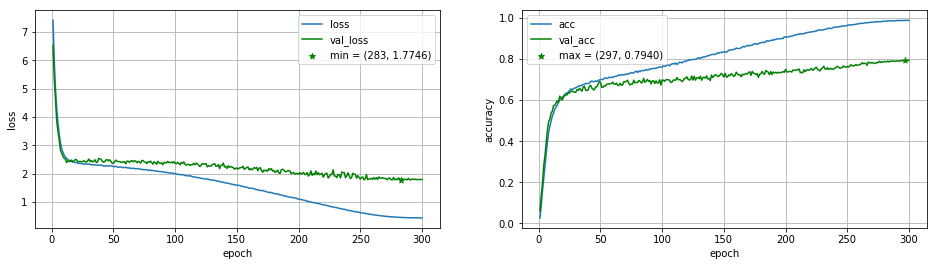

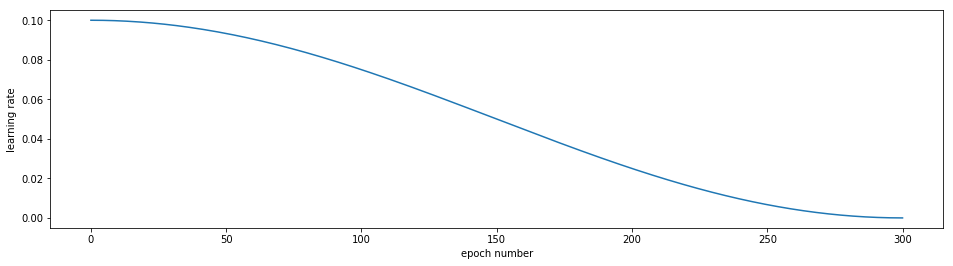

In [8]:
#plot loss and accuracy
plot_history(model.history.history)

#plot learning rate schedule
plt.figure(figsize=(16,4))
plt.plot(np.arange(0,len(lr_scheduler.lr_used))/steps_per_epoch,lr_scheduler.lr_used)
plt.xlabel('epoch number')
plt.ylabel('learning rate')
plt.show()

In [9]:
#save the weigts used for updating
model.save_weights(ModelsPath+'Final_weights_'+WhichDataSet+'_32bit_model_sReLU.h5')